# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [19]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

#### Portfolio Dataset

In [5]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


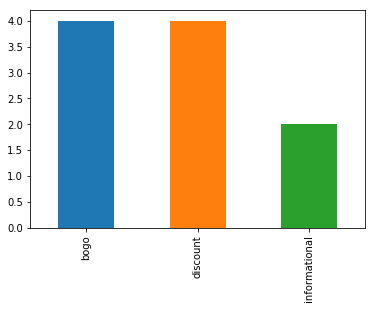

In [12]:
pd.value_counts(portfolio['offer_type']).plot.bar()

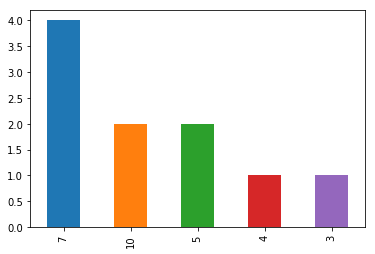

In [13]:
pd.value_counts(portfolio['duration']).plot.bar()

**Observations**

* From the above frequency charts, it is observed that BOGO and Discount are the most prevelant offer types in the portfolio datasets. 
* 7 days is the highest number of occurences for the number of days the offers are going to be live in the market

#### Profile Dataset

In [15]:
profile.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
5,68,20180426,M,e2127556f4f64592b11af22de27a7932,70000.0
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
8,65,20180209,M,389bc3fa690240e798340f5a15918d5c,53000.0
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN


In [17]:
profile.describe(include="all")

,age,became_member_on,gender,id,income
count,17000.000000,1.700000e+04,14825,17000,14825.000000
unique,NaN,NaN,3,17000,NaN
top,NaN,NaN,M,be7118b321cf45309618ddf31872648f,NaN
freq,NaN,NaN,8484,1,NaN
mean,62.531412,2.016703e+07,NaN,NaN,65404.991568
std,26.738580,1.167750e+04,NaN,NaN,21598.299410
min,18.000000,2.013073e+07,NaN,NaN,30000.000000
25%,45.000000,2.016053e+07,NaN,NaN,49000.000000
50%,58.000000,2.017080e+07,NaN,NaN,64000.000000
75%,73.000000,2.017123e+07,NaN,NaN,80000.000000


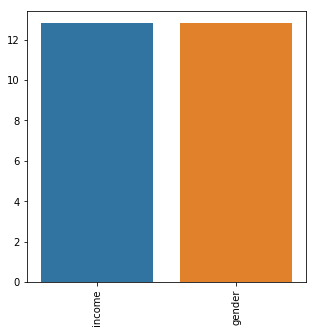

In [21]:
missing_values = (profile.isna().sum() * 100 / profile.shape[0]).sort_values(ascending=False)
plt.figure(figsize = (5,5))
sns.barplot(missing_values[missing_values > 0].index, missing_values[missing_values > 0].values)
plt.xticks(rotation = 'vertical')
plt.show()

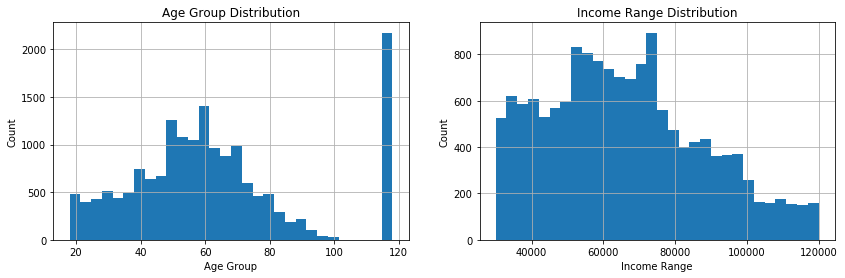

In [26]:
plt.figure(figsize = (14,4))
plt.subplot(1,2,1)
profile.age.hist(bins = 30)
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.title('Age Group Distribution')

plt.subplot(1,2,2)
profile.income.hist(bins = 30);
plt.xlabel('Income Range')
plt.ylabel('Frequency')
plt.title('Income Range Distribution');

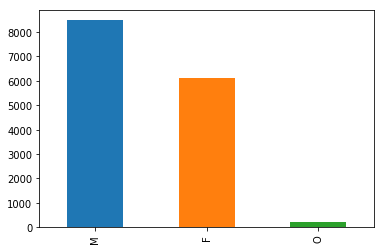

In [31]:
pd.value_counts(profile['gender']).plot.bar()

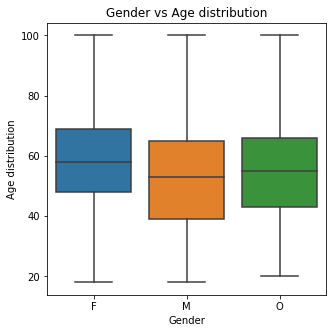

In [32]:
plt.figure(figsize = (5,5))
sns.boxplot(x=profile.gender, y =profile.age, data = profile, showfliers = False)
plt.title('Gender vs Age distribution')
plt.xlabel("Gender")
plt.ylabel("Age distribution")
plt.show()

**Observations**

* Income and age has the highest missing values out of all the columns in the dataset
* Some outlier age is present in the data which is more than 115
* The average age of users is between 50-62 years in the dataset
* Average income user is within the range 65000-70000
* With respect to gender, the highest observations are for Males followed by females in the dataset
* The median age for all genders is distributed within the range 55-60 in the data

#### Transcript Dataset

In [33]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [35]:
transcript.describe(include="all")

,event,person,time,value
count,306534,306534,306534.000000,306534
unique,4,17000,NaN,5121
top,transaction,94de646f7b6041228ca7dec82adb97d2,NaN,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
freq,138953,51,NaN,14983
mean,NaN,NaN,366.382940,NaN
std,NaN,NaN,200.326314,NaN
min,NaN,NaN,0.000000,NaN
25%,NaN,NaN,186.000000,NaN
50%,NaN,NaN,408.000000,NaN
75%,NaN,NaN,528.000000,NaN


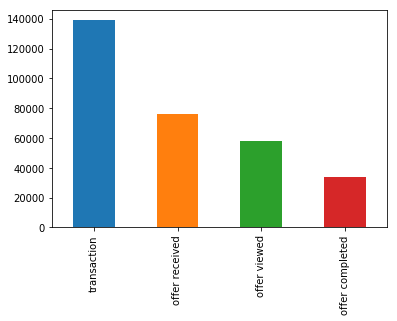

In [36]:
pd.value_counts(transcript['event']).plot.bar()

In [53]:
per_person_value = transcript[transcript['event'] == 'offer received'].groupby(['person'], as_index = False).agg({'value':'count'})
per_person_value.describe()

,value
count,16994.000000
mean,4.488467
std,1.073047
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,6.000000


**Observations**

* On an average, 4 offers were received at a user level
* The maximum number of offers received were 6 for a person
* The different types of events in the transcript dataseta are transaction, offer received, offer viewed and offer completed

### Data Cleaning

#### Portfolio

In [54]:
def column_naming(df, new_cols_name):
    """
    Input
    df: input dataframe for renaming columns
    new_cols_name: define new column name for each column
    
    Output
    df: output data frame with renamed column names
    """
    df= df.rename(columns = new_cols_name)
    return df

In [55]:
portfolio_renamed_cols = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
portfolio_renamed = column_naming(portfolio, renamed_cols)

In [56]:
portfolio_renamed.head(2)

,channels,offer_difficulty,offer_duration,offer_id,offer_type,offer_reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


#### Profile

In [58]:
profile_renamed_cols = {'id':'customer_id' , 'income':'customer_income'}
profile_renamed = column_naming(profile, profile_renamed_cols)

In [59]:
profile_renamed.head(2)

,age,became_member_on,gender,customer_id,customer_income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
